# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# In order to run the notebook you have to first load [kaggle API token](https://miro.medium.com/max/1400/1*-D3PXoaRd-SYKM7QN933TA.png) (kaggle.json) into colab root folder. This is necessary for downloading dataset from kaggle.
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# A dive into soccer smart storytelling and predictions with data science

Ivan Poliakov (studentID: i6211798)

Maastricht University 2021

# Ethical Considerations

1. The dataset was found on Kaggle: https://www.kaggle.com/datasets/hugomathien/soccer 

2. The dataset was published on Kaggle and therefore the sources were verified beforehand already by the community. Moreover, I performed additional verification myself which I will mention further.

3. The project is intended for educational purposes.

4. Regarding ethical considerations about analysis, conclusions and potential benefitting and suffering parties: for the most part the project is centered around soccer statistics, predictions and storytelling, therefore the main benefit is going to be for the soccer fanbase. However, we do make predictions for individual players potential growth. This is based solely on sports statistics in public domain, therefore are not restricted for usage. Also, those statistics do not include race, religion, language, individual sicknesses and any other personal information not related to explicit soccer statistics. The only concern could be that the player professional growth prediction models become too good which can lead to player scouts losing their jobs and soccer players being involved in a more totalitarian selection process. However, this model quality is currently impossible to achieve, so I hope that such projects could assist club scouts with their work instead of completely replacing them and provide practical insights for the players themselves. Soccer is a difficult team game where players play different roles based on their skills, so I believe that there such models will not discriminate certain playing styles entirely but rather provide guidence as to with what additions to complete those styles.



This project is, however, much more limited than its more powerful successors that will have to be regulated. First I would like to explore alternative representations of scoreboards on example of English Premiere League(EPL) season 2015/2016. Then I would like to analyze individual players statistics utilizing the data for all leagues and seasons in the dataset. I will take statistics for season 2008/2009 and train a model that based on the statistics of this very season will predict the player's maximum rating across the next 5 seasons.

# EDA



In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model as lm
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

Collecting the dataset

In [2]:
! git clone https://github.com/M1v1savva/data_madness
path = 'data/'
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d hugomathien/soccer
! unzip soccer.zip
! rm soccer.zip
! git clone https://github.com/ekansa/sqlite-dump-to-csv
! cp -r data_madness/data data
! python sqlite-dump-to-csv/sqlite_dump.py --db database.sqlite --output data/

Cloning into 'data_madness'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 0), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 18% 6.00M/32.7M [00:00<00:00, 60.9MB/s]
100% 32.7M/32.7M [00:00<00:00, 173MB/s] 
Archive:  soccer.zip
  inflating: database.sqlite         
Cloning into 'sqlite-dump-to-csv'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), done.
Output: sqlite_sequence.csv
Output: Player_Attributes.csv
Output: Player.csv
Output: Match.csv
Output: League.csv
Output: Country.csv
Output: Team.csv
Output: Team_Attributes.csv
Done! data/


Load the dataset. The dataset was originally downloaded as a raw .zip from Kaggle, unpacked the archive, and then .sqlite database to .csv dataframes with the following script(use the same folder where you unpacked .sqlite database):


```
git clone https://github.com/ekansa/sqlite-dump-to-csv
mkdir data
cd sqlite-dump-to-csv
python3 sqlite_dump.py --db ../database.sqlite --output ../data/
```

In [3]:
match_df = pd.read_csv(path + 'Match.csv')
player_df = pd.read_csv(path + 'Player.csv')
fifa_df = pd.read_csv(path + 'Player_Attributes.csv')
team_df = pd.read_csv(path + 'Team.csv')
teamatt_df = pd.read_csv(path + 'Team_Attributes.csv')

I load additional leaderboards collected from [this website](https://thefishy.co.uk/leaguetable.php?table=1&season=6). Since the main dataset is represented by a set of games, I decided to fact-check the database for match duplicates or absences by calculating the leaderboard from the games data and then comparing it to the ground truth. I did it for all EPL seasons represented in the database (2008/2009 to 20015/2016). 

In [4]:
leaderb_df = [None] * 7
add_path = ['s2008.csv',
            's2009.csv',
            's2010.csv',
            's2011.csv',
            's2012.csv',
            's2013.csv',
            's2014.csv']
for i in range(7):
    leaderb_df[i] = pd.read_csv(path + add_path[i], encoding='latin-1', sep=';')
leaderb_df[0].head()

,Pos,Team,P,HW,HD,HL,HF,HA,AW,AD,AL,AF,AA,GD,Pts,PPG
0,1,Man Utd,38,16,2,1,43,13,12,4,3,25,11,44,90,ôåâ.36
1,2,Liverpool,38,12,7,0,41,13,13,4,2,36,14,50,86,ôåâ.26
2,3,Chelsea,38,11,6,2,33,12,14,2,3,35,12,44,83,ôåâ.18
3,4,Arsenal,38,11,5,3,31,16,9,7,3,37,21,31,72,ÿíâ.89
4,5,Everton,38,8,6,5,31,20,9,6,4,24,17,18,63,ÿíâ.65


Extract specifically EPL games.

In [5]:
match_df = match_df.loc[match_df['league_id'] == 1729]
match_df.reset_index(inplace=True, drop=True)
pd.set_option('display.max_columns', None)
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,1,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,5.0,5.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,9.0,11.0,30726.0,30362.0,30620.0,30865.0,32569.0,24148.0,34944.0,30373.0,24154.0,24157.0,30829.0,24224.0,25518.0,24228.0,30929.0,29581.0,38807.0,40565.0,30360.0,33852.0,34574.0,37799.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...,1.29,5.5,11.00,1.30,4.75,8.25,1.3,4.4,8.50,1.25,4.5,10.00,NaN,NaN,NaN,1.25,4.5,10.00,1.25,5.00,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,5.0,7.0,9.0,1.0,3.0,5.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,7.0,11.0,23686.0,26111.0,38835.0,30986.0,31291.0,31013.0,30935.0,39297.0,26181.0,30960.0,36410.0,36373.0,36832.0,23115.0,37280.0,24728.0,24664.0,31088.0,23257.0,24171.0,25922.0,27267.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...,1.20,6.5,15.00,1.22,5.50,10.00,1.2,5.2,11.00,1.20,5.0,11.00,NaN,NaN,NaN,1.17,5.5,12.00,1.20,5.50,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,1,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,32562.0,38836.0,24446.0,24408.0,36786.0,38802.0,24655.0,17866.0,30352.0,23927.0,24410.0,30660.0,37442.0,30617.0,24134.0,414792.0,37139.0,30618.0,40701.0,24800.0,24635.0,30853.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45

Function that calculates game score changes for each game and replace club ids with club names.

In [6]:
def get_match_results(df):
    rounds_df = pd.DataFrame(columns = ['id', 'season', 'stage', 
                                    'home_team_api_id', 'away_team_api_id', 
                                    'home_team_result', 'away_team_result', 
                                    'home_team_goal', 'away_team_goal'])

    for index, ser_row in df.iterrows():
        cur_dict = dict()
        row = ser_row.to_dict()
        for key in rounds_df.columns:
            if key in row.keys():
                cur_dict[key] = row[key]
        if row['home_team_goal'] > row['away_team_goal']:
            cur_dict['home_team_result'] = 3
            cur_dict['away_team_result'] = 0
        elif row['home_team_goal'] < row['away_team_goal']:
            cur_dict['home_team_result'] = 0
            cur_dict['away_team_result'] = 3
        else:
            cur_dict['home_team_result'] = 1
            cur_dict['away_team_result'] = 1
        rounds_df = rounds_df.append(cur_dict, ignore_index=True)

    return rounds_df

Function that returns the number of stages secribed in the dataframe.

In [7]:
def get_stages(df, season):
    return len(df.loc[df['season'] == season, 'stage'].unique())

Function that calculates leaderboard for a given season and a prefix of stages.

In [8]:
def get_leaderboard(df, season, stage=-1):
    if stage == -1:
        stage = get_stages(df, season)
    results = pd.DataFrame()
    cur_df = df.loc[(df['season'] == season) & (df['stage'] <= stage)]
    
    results['team_api_id'] = cur_df['home_team_api_id'].unique()
    results['score'] = 0
    results['club_name'] = '.'

    for index, ser_row in cur_df.iterrows():
        row = ser_row.to_dict()
        results.loc[results['team_api_id'] == row['home_team_api_id'], 'score'] += row['home_team_result']
        results.loc[results['team_api_id'] == row['away_team_api_id'], 'score'] += row['away_team_result']
    for index, ser_row in results.iterrows():
        row = ser_row.to_dict()
        results.loc[index, 'club_name'] = \
        team_df.loc[team_df['team_api_id'] == row['team_api_id'], 'team_long_name'].iloc[0]
    results = results.sort_values(by='score', ascending=False)
    prev_score = 100
    pos = 0
    buf = 0
    results.reset_index(drop=True, inplace=True)
    for index, ser_row in results.iterrows():
        if prev_score != results.iloc[index]['score']:
            pos += 1 + buf
            buf = 0 
            prev_score = results.iloc[index]['score']
        else:
            buf += 1
        results.at[index, 'position'] = pos
    results['position'] = results['position'].astype(int)
    return results

Function that performs fact check on the completeness of the games list.

In [9]:
def fact_check(df):
    leaderb = [None] * 7
    seasons = ['2008/2009', 
               '2009/2010', 
               '2010/2011', 
               '2011/2012', 
               '2012/2013',
               '2013/2014',
               '2014/2015',
               '2015/2016']
    for i in range(7):
        leaderb[i] = get_leaderboard(df, seasons[i])

    res = True
    for i in range(7):
        if not (leaderb[i]['score'].to_numpy() == leaderb_df[i]['Pts'].to_numpy()).all():
            res = False
            print(leaderb[i]['score'])
            print(leaderb_df[i]['Pts'])
            print(seasons[i])
    return res

In [10]:
relevant_games_df = get_match_results(match_df)

In [11]:
relevant_games_df.head()

,id,season,stage,home_team_api_id,away_team_api_id,home_team_result,away_team_result,home_team_goal,away_team_goal
0,1729,2008/2009,1,10260,10261,1,1,1,1
1,1730,2008/2009,1,9825,8659,3,0,1,0
2,1731,2008/2009,1,8472,8650,0,3,0,1
3,1732,2008/2009,1,8654,8528,3,0,2,1
4,1733,2008/2009,1,10252,8456,3,0,4,2


In [12]:
print(fact_check(relevant_games_df))

0     86
1     85
2     75
3     70
4     67
5     64
6     63
7     61
8     50
9     50
10    47
11    46
12    44
13    39
14    38
15    36
16    35
17    30
18    30
19    28
Name: score, dtype: int64
0     86
1     85
2     75
3     70
4     67
5     64
6     63
7     61
8     50
9     50
10    47
11    46
12    44
13    39
14    38
15    36
16    35
17    30
18    30
19    19
Name: Pts, dtype: int64
2009/2010
False


In [13]:
scoreboard_df = get_leaderboard(relevant_games_df, '2009/2010')

In [14]:
scoreboard_df

,team_api_id,score,club_name,position
0,8455,86,Chelsea,1
1,10260,85,Manchester United,2
2,9825,75,Arsenal,3
3,8586,70,Tottenham Hotspur,4
4,8456,67,Manchester City,5
5,10252,64,Aston Villa,6
6,8650,63,Liverpool,7
7,8668,61,Everton,8
8,8655,50,Blackburn Rovers,9
9,8658,50,Birmingham City,9


Turns out that during season 2009/2010 Portsmouth FC went into [administration](https://en.wikipedia.org/wiki/Administration_(British_football)) and was punished by 9 points for that. This is not specifically relevant but it shows that such fact checks are important. The games list itself was correct, however, it does not take into account various league sanctions towards certain clubs.

Now I would like to show my vision as to how soccer game leaderboards could be represented with preserved dynamics of the stages and rivalry.

In [15]:
num_stages = get_stages(relevant_games_df, '2015/2016')
num_stages

38

In [16]:
lb2015 = [None] * num_stages
for i in range(num_stages):
    lb2015[i] = get_leaderboard(relevant_games_df, '2015/2016', i + 1)
print(lb2015[0])

  team_api_id  score             club_name  position
0        8197      3        Leicester City         1
1       10260      3     Manchester United         1
2        8455      1               Chelsea         3
3        8668      1               Everton         3
4       10261      1      Newcastle United         3
5        9825      0               Arsenal         6
6        8678      0           Bournemouth         6
7        9850      0          Norwich City         6
8       10194      0            Stoke City         6
9        8659      0  West Bromwich Albion         6


In [17]:
top_clubs = []
for i in range(num_stages):
    top_clubs.extend(lb2015[i].loc[lb2015[i]['position'] <= 5, 'club_name'].unique())
top_clubs = list(set(top_clubs))
top_clubs

['Manchester United',
 'Newcastle United',
 'Chelsea',
 'Leicester City',
 'West Ham United',
 'Liverpool',
 'Manchester City',
 'Arsenal',
 'Everton',
 'Tottenham Hotspur',
 'Crystal Palace',
 'Swansea City']

In [18]:
xs = range(1, num_stages + 1)
ys = []
p1_df = pd.DataFrame()
p1_df['stage'] = range(1, num_stages + 1)
for j in range(len(top_clubs)):
    cur = []
    for i in range(num_stages):
        try:
            cur.append(lb2015[i].loc[lb2015[i]['club_name'] == top_clubs[j], 'position'].iloc[0])
        except:
            cur.append(lb2015[i].iloc[-1]['position'])
    p1_df[top_clubs[j]] = cur
p1_df.head()

,stage,Manchester United,Newcastle United,Chelsea,Leicester City,West Ham United,Liverpool,Manchester City,Arsenal,Everton,Tottenham Hotspur,Crystal Palace,Swansea City
0,1,1,3,3,1,6,6,6,6,3,6,6,6
1,2,1,13,13,1,7,1,1,7,5,13,7,5
2,3,2,15,7,2,11,2,1,7,7,15,5,6
3,4,5,18,11,3,8,5,1,5,9,16,2,3
4,5,3,18,15,2,5,9,1,3,7,11,5,7


In [19]:
grs = p1_df.groupby(by='stage').mean()
grs.describe()

,Manchester United,Newcastle United,Chelsea,Leicester City,West Ham United,Liverpool,Manchester City,Arsenal,Everton,Tottenham Hotspur,Crystal Palace,Swansea City
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,4.052632,17.210526,12.184211,1.684211,5.921053,7.210526,2.842105,2.789474,9.710526,4.789474,9.631579,13.105263
std,1.541277,2.732763,2.807858,1.254296,1.633791,1.773040,1.461697,1.527370,2.470451,3.534830,4.504779,3.902802
min,1.000000,3.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,3.000000
25%,3.000000,17.000000,10.000000,1.000000,5.000000,7.000000,1.000000,2.000000,8.250000,2.000000,6.000000,11.000000
50%,4.500000,18.000000,13.000000,1.000000,6.000000,7.000000,3.000000,3.000000,11.000000,4.000000,8.000000,14.500000
75%,5.000000,18.000000,14.000000,2.000000,6.000000,8.000000,4.000000,3.000000,11.000000,5.000000,14.000000,16.000000
max,6.000000,19.000000,16.000000,5.000000,11.000000,11.000000,6.000000,7.000000,14.000000,16.000000,16.000000,18.000000


In this plot we can see the dynamics of the leaderboard motion of the teams that at least once throughout the season could achieve top-5 in the league. The intersections of lines suggest crucial moments of rivalry when the first team to lose points loses its position. In my opinion such plots are highly underrated among websites dedicated to soccer journalism.

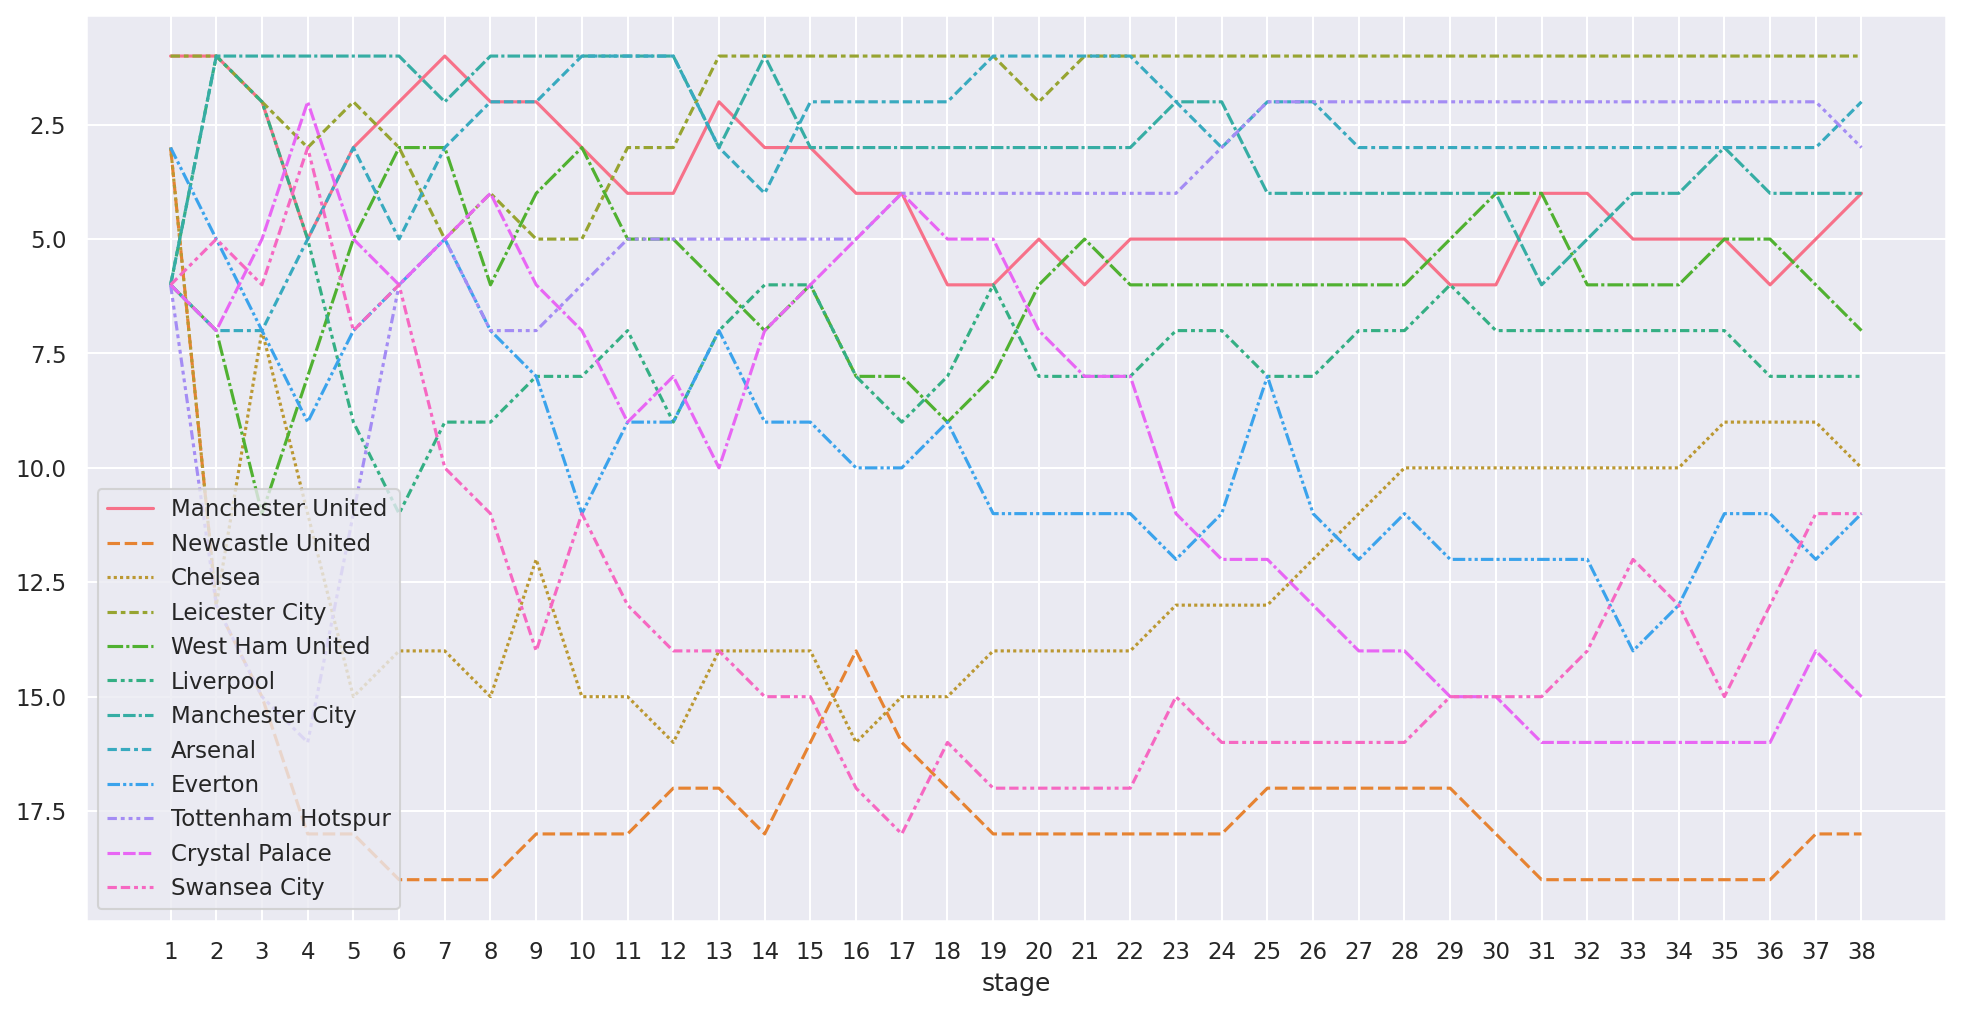

In [49]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

p = sns.lineplot(data=grs)
p.invert_yaxis()
plt.xticks(range(1, num_stages + 1))
plt.show()

# Analysis

First I have to extract statistics for all players who played from season 2008/2009 all the way until 2015/2016. Since the model is intended to predict the professional growth of a player it is important to consider the same time intervals for everyone.

In [21]:
full_match_df = pd.read_csv(path + 'Match.csv')
seas1 = full_match_df.loc[full_match_df['season'] == '2008/2009']
seas1.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [22]:
players = []
for i in range(1, 11 + 1):
    players.extend(seas1['home_player_' + str(i)].to_numpy())
    players.extend(seas1['away_player_' + str(i)].to_numpy())

players = np.array(list(set(players)))
ps = [item for item in players if not np.isnan(item)]

In [23]:
fifa_df1 = fifa_df[fifa_df['player_api_id'].isin(players)]
fifa_df1 = fifa_df1.sort_values(by='date')
fifa_df1.shape

(65876, 42)

In [24]:
fifa_df1 = fifa_df1.dropna()
fifa_df1.shape

(63221, 42)

We just extracted the player list. Now it is time to clean it. Since a lot of cleaning is essential for working with the given dataset and must be done in any case, a lot of cleaning will be done outside of the reusable pipeline.

In [25]:
fifa_df1.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
183977,183978,102359,39902,2007-02-22 00:00:00,80.0,81.0,right,medium,low,74.0,68.0,57.0,88.0,77.0,87.0,86.0,53.0,78.0,91.0,58.0,64.0,77.0,66.0,73.0,72.0,58.0,67.0,59.0,78.0,63.0,63.0,68.0,88.0,53.0,38.0,32.0,30.0,9.0,9.0,78.0,7.0,15.0
131151,131152,140601,30865,2007-02-22 00:00:00,79.0,83.0,right,medium,high,41.0,30.0,81.0,71.0,41.0,42.0,43.0,61.0,53.0,68.0,69.0,73.0,52.0,76.0,84.0,56.0,92.0,79.0,81.0,47.0,82.0,81.0,84.0,63.0,61.0,76.0,82.0,85.0,10.0,12.0,53.0,18.0,6.0
164489,164490,172425,34654,2007-02-22 00:00:00,59.0,73.0,right,medium,medium,37.0,23.0,60.0,51.0,20.0,23.0,33.0,20.0,47.0,41.0,71.0,76.0,63.0,48.0,81.0,46.0,71.0,57.0,76.0,23.0,66.0,58.0,51.0,77.0,54.0,53.0,57.0,66.0,7.0,23.0,47.0,23.0,23.0
70243,70244,187323,128037,2007-02-22 00:00:00,74.0,82.0,right,medium,low,26.0,26.0,65.0,55.0,58.0,55.0,33.0,31.0,43.0,61.0,76.0,71.0,67.0,72.0,70.0,63.0,75.0,81.0,74.0,59.0,79.0,62.0,69.0,69.0,70.0,77.0,81.0,78.0,4.0,22.0,43.0,22.0,22.0
29559,29560,159265,50669,2007-02-22 00:00:00,57.0,62.0,right,medium,medium,20.0,20.0,21.0,41.0,10.0,23.0,8.0,24.0,50.0,20.0,39.0,42.0,48.0,43.0,66.0,33.0,73.0,61.0,68.0,20.0,29.0,19.0,21.0,43.0,39.0,20.0,21.0,33.0,65.0,50.0,50.0,50.0,65.0


In [26]:
fifa_df1 = fifa_df1.loc[fifa_df1['date'] >= '2008']
fifa_df1.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
25151,25152,167834,32713,2008-02-22 00:00:00,53.0,65.0,right,medium,medium,22.0,25.0,38.0,45.0,33.0,35.0,25.0,28.0,48.0,23.0,24.0,34.0,52.0,52.0,64.0,26.0,67.0,51.0,53.0,24.0,36.0,44.0,42.0,41.0,46.0,34.0,43.0,36.0,54.0,56.0,48.0,52.0,53.0
162150,162151,29118,30776,2008-02-22 00:00:00,79.0,74.0,right,medium,medium,78.0,24.0,68.0,80.0,63.0,81.0,81.0,77.0,72.0,85.0,70.0,69.0,72.0,75.0,61.0,74.0,66.0,79.0,77.0,69.0,76.0,81.0,77.0,81.0,63.0,68.0,69.0,62.0,15.0,9.0,72.0,5.0,10.0
75148,75149,150680,26308,2008-02-22 00:00:00,74.0,76.0,right,norm,ormal,45.0,41.0,79.0,69.0,24.0,35.0,37.0,40.0,60.0,67.0,48.0,55.0,42.0,72.0,71.0,54.0,76.0,74.0,78.0,52.0,66.0,58.0,73.0,38.0,58.0,73.0,70.0,69.0,6.0,25.0,60.0,25.0,25.0
88749,88750,157682,22234,2008-02-22 00:00:00,79.0,80.0,right,medium,medium,76.0,82.0,70.0,75.0,71.0,76.0,76.0,70.0,59.0,73.0,83.0,84.0,73.0,76.0,67.0,75.0,69.0,80.0,65.0,76.0,74.0,78.0,77.0,64.0,72.0,66.0,55.0,17.0,7.0,20.0,59.0,20.0,20.0
175645,175646,175895,38366,2008-02-22 00:00:00,62.0,73.0,right,medium,low,58.0,46.0,49.0,63.0,63.0,64.0,63.0,48.0,60.0,69.0,64.0,69.0,71.0,60.0,72.0,53.0,69.0,66.0,63.0,56.0,51.0,47.0,44.0,75.0,62.0,67.0,60.0,68.0,1.0,23.0,60.0,23.0,23.0


Restrict the dataset to just one row for each player, each player has to play in every season from 2008/2009 to 2015/2016.

In [27]:
fifa_df2 = pd.DataFrame()
available_players = set(fifa_df1.loc[fifa_df1['date'] >= '2013', 'player_api_id'])
added_players = set()
max_rating = dict()

for index, ser_row in fifa_df1.iterrows():
    row = ser_row.to_dict()
    if row['player_api_id'] not in available_players:
        continue
    
    if row['player_api_id'] in max_rating.keys():
        max_rating[row['player_api_id']] = max(max_rating[row['player_api_id']], row['overall_rating'])
    else:
        max_rating[row['player_api_id']] = row['overall_rating']
    if row['player_api_id'] in added_players:
        continue
    added_players.add(row['player_api_id'])
    fifa_df2 = fifa_df2.append(row, ignore_index=True)
fifa_df2.shape

(2677, 42)

Add additional data from another .csv file: height, weight, birthday. Agism is, unfortunately, inevitable in professional sport. Here we also calculate player max ratings throughout all seasons. 

In [28]:
birthday = []
height = []
weight = []
max_rt = []
for index, ser_row in fifa_df2.iterrows():
    row = ser_row.to_dict()
    row_player = player_df.loc[player_df['player_api_id'] == row['player_api_id']].iloc[0]
    max_rt.append(max_rating[row['player_api_id']])
    birthday.append(row_player['birthday'][:4])
    height.append(row_player['height'])
    weight.append(row_player['weight'])
fifa_df3 = fifa_df2.copy()
fifa_df3['birthday'] = birthday
fifa_df3['height'] = height
fifa_df3['weight'] = weight
fifa_df3['max_rating'] = max_rt
fifa_df3 = fifa_df3.drop('id', axis=1)
fifa_df3 = fifa_df3.drop('player_fifa_api_id', axis=1)
fifa_df3 = fifa_df3.drop('player_api_id', axis=1)
fifa_df3 = fifa_df3.drop('date', axis=1)
fifa_df3.head()

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,birthday,height,weight,max_rating
0,53.0,65.0,right,medium,medium,22.0,25.0,38.0,45.0,33.0,35.0,25.0,28.0,48.0,23.0,24.0,34.0,52.0,52.0,64.0,26.0,67.0,51.0,53.0,24.0,36.0,44.0,42.0,41.0,46.0,34.0,43.0,36.0,54.0,56.0,48.0,52.0,53.0,1986,180.34,174,70.0
1,79.0,74.0,right,medium,medium,78.0,24.0,68.0,80.0,63.0,81.0,81.0,77.0,72.0,85.0,70.0,69.0,72.0,75.0,61.0,74.0,66.0,79.0,77.0,69.0,76.0,81.0,77.0,81.0,63.0,68.0,69.0,62.0,15.0,9.0,72.0,5.0,10.0,1979,175.26,163,79.0
2,79.0,80.0,right,medium,medium,76.0,82.0,70.0,75.0,71.0,76.0,76.0,70.0,59.0,73.0,83.0,84.0,73.0,76.0,67.0,75.0,69.0,80.0,65.0,76.0,74.0,78.0,77.0,64.0,72.0,66.0,55.0,17.0,7.0,20.0,59.0,20.0,20.0,1978,182.88,172,79.0
3,62.0,73.0,right,medium,low,58.0,46.0,49.0,63.0,63.0,64.0,63.0,48.0,60.0,69.0,64.0,69.0,71.0,60.0,72.0,53.0,69.0,66.0,63.0,56.0,51.0,47.0,44.0,75.0,62.0,67.0,60.0,68.0,1.0,23.0,60.0,23.0,23.0,1989,185.42,201,74.0
4,77.0,65.0,left,high,medium,78.0,69.0,60.0,83.0,65.0,77.0,72.0,67.0,74.0,68.0,67.0,68.0,68.0,69.0,59.0,77.0,65.0,72.0,66.0,60.0,73.0,69.0,69.0,59.0,59.0,24.0,25.0,19.0,11.0,24.0,74.0,24.0,24.0,1981,182.88,172,77.0


Since goalkeeper's stats are drastically different from the rest of the playing positions it was decided to remove them completely as goalkeepers would probably require a separate model for good predictions. I also deleted goalkeeping stats for in-the-field players, since those stats are not relevant for them.

In [29]:
gk_atts = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
fifa_df4 = pd.DataFrame()
for index, ser_row in fifa_df3.iterrows():
    row = ser_row.to_dict()
    vals = [0] * 5
    for i in range(len(gk_atts)):
        vals[i] = row[gk_atts[i]]
    if min(vals) < 40:
        fifa_df4 = fifa_df4.append(row, ignore_index=True)
fifa_df4.head()

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,birthday,height,weight,max_rating
0,79.0,74.0,right,medium,medium,78.0,24.0,68.0,80.0,63.0,81.0,81.0,77.0,72.0,85.0,70.0,69.0,72.0,75.0,61.0,74.0,66.0,79.0,77.0,69.0,76.0,81.0,77.0,81.0,63.0,68.0,69.0,62.0,15.0,9.0,72.0,5.0,10.0,1979,175.26,163.0,79.0
1,79.0,80.0,right,medium,medium,76.0,82.0,70.0,75.0,71.0,76.0,76.0,70.0,59.0,73.0,83.0,84.0,73.0,76.0,67.0,75.0,69.0,80.0,65.0,76.0,74.0,78.0,77.0,64.0,72.0,66.0,55.0,17.0,7.0,20.0,59.0,20.0,20.0,1978,182.88,172.0,79.0
2,62.0,73.0,right,medium,low,58.0,46.0,49.0,63.0,63.0,64.0,63.0,48.0,60.0,69.0,64.0,69.0,71.0,60.0,72.0,53.0,69.0,66.0,63.0,56.0,51.0,47.0,44.0,75.0,62.0,67.0,60.0,68.0,1.0,23.0,60.0,23.0,23.0,1989,185.42,201.0,74.0
3,77.0,65.0,left,high,medium,78.0,69.0,60.0,83.0,65.0,77.0,72.0,67.0,74.0,68.0,67.0,68.0,68.0,69.0,59.0,77.0,65.0,72.0,66.0,60.0,73.0,69.0,69.0,59.0,59.0,24.0,25.0,19.0,11.0,24.0,74.0,24.0,24.0,1981,182.88,172.0,77.0
4,69.0,79.0,right,high,low,75.0,61.0,45.0,67.0,54.0,72.0,66.0,65.0,54.0,76.0,82.0,78.0,71.0,74.0,64.0,70.0,63.0,76.0,69.0,61.0,48.0,64.0,61.0,65.0,68.0,23.0,46.0,51.0,12.0,21.0,54.0,21.0,21.0,1983,182.88,185.0,70.0


In [30]:
fifa_df4 = fifa_df4.drop(gk_atts, axis=1)

In [31]:
fifa_df4.head()

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,birthday,height,weight,max_rating
0,79.0,74.0,right,medium,medium,78.0,24.0,68.0,80.0,63.0,81.0,81.0,77.0,72.0,85.0,70.0,69.0,72.0,75.0,61.0,74.0,66.0,79.0,77.0,69.0,76.0,81.0,77.0,81.0,63.0,68.0,69.0,62.0,1979,175.26,163.0,79.0
1,79.0,80.0,right,medium,medium,76.0,82.0,70.0,75.0,71.0,76.0,76.0,70.0,59.0,73.0,83.0,84.0,73.0,76.0,67.0,75.0,69.0,80.0,65.0,76.0,74.0,78.0,77.0,64.0,72.0,66.0,55.0,17.0,1978,182.88,172.0,79.0
2,62.0,73.0,right,medium,low,58.0,46.0,49.0,63.0,63.0,64.0,63.0,48.0,60.0,69.0,64.0,69.0,71.0,60.0,72.0,53.0,69.0,66.0,63.0,56.0,51.0,47.0,44.0,75.0,62.0,67.0,60.0,68.0,1989,185.42,201.0,74.0
3,77.0,65.0,left,high,medium,78.0,69.0,60.0,83.0,65.0,77.0,72.0,67.0,74.0,68.0,67.0,68.0,68.0,69.0,59.0,77.0,65.0,72.0,66.0,60.0,73.0,69.0,69.0,59.0,59.0,24.0,25.0,19.0,1981,182.88,172.0,77.0
4,69.0,79.0,right,high,low,75.0,61.0,45.0,67.0,54.0,72.0,66.0,65.0,54.0,76.0,82.0,78.0,71.0,74.0,64.0,70.0,63.0,76.0,69.0,61.0,48.0,64.0,61.0,65.0,68.0,23.0,46.0,51.0,1983,182.88,185.0,70.0


Function for one-hot encoding.

In [32]:
def ohe_encode(data, feat, pref):
    res = pd.get_dummies(data,
                          prefix=pref,
                          columns=[feat])
    return res

Function for column standartization.

In [33]:
def standardize_columns(data):
    standardized_data=(data-data.mean())/data.std()
    standardized_data.fillna(0, inplace=True)
    return standardized_data

Function for deleting data rows with missing or non-mainstream field values that are hard to include in the feature engineering.

In [34]:
def clean_data(data):
    res = data.drop(data.loc[(data['preferred_foot'] != 'right') & (data['preferred_foot'] != 'left')].index)
    res = data.drop(data.loc[(data['attacking_work_rate'] != 'high') & (data['attacking_work_rate'] != 'medium') & (data['attacking_work_rate'] != 'low')].index)
    res = data.drop(data.loc[(data['defensive_work_rate'] != 'high') & (data['defensive_work_rate'] != 'medium') & (data['defensive_work_rate'] != 'low')].index)
    return res

Transform the dataframe into numerical one.

In [35]:
def apply_numeric(data):
    return data.apply(pd.to_numeric)

In [36]:
fifa_df5 = clean_data(fifa_df4)
print(fifa_df5['attacking_work_rate'].unique())
print(fifa_df5['defensive_work_rate'].unique())
print(fifa_df5['preferred_foot'].unique())

['medium' 'high' 'low' 'None']
['medium' 'low' 'high']
['right' 'left']


Reusable pipeline.

In [37]:
def process_data(data):
    data = (
        data
        .pipe(clean_data)
        .pipe(ohe_encode, 'preferred_foot', 'pf')
        .pipe(ohe_encode, 'attacking_work_rate', 'awr')
        .pipe(ohe_encode, 'defensive_work_rate', 'dwr')
        .pipe(apply_numeric)
    ) 
    
    X = standardize_columns(data).drop(['max_rating'], axis = 1)
    y = data['max_rating']
    return X, y

Pass the data through the pipeline.

In [38]:
train, test = train_test_split(fifa_df4, test_size=0.2)
X_train, y_train = process_data(train)
X_test, y_test = process_data(test)

In [39]:
X_train.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,birthday,height,weight,pf_left,pf_right,awr_None,awr_high,awr_low,awr_medium,dwr_high,dwr_low,dwr_medium
2001,-1.586817,0.136468,0.070220,0.307847,-0.167877,0.102167,0.127065,-0.201964,0.001886,0.107982,-0.047214,-0.378048,-0.402918,-1.132458,0.543759,-0.060429,-0.179525,-0.127817,-0.575645,-0.681148,-0.019587,-0.479133,0.734503,0.230828,0.655613,0.774165,-0.825146,-0.925381,-0.855270,-0.114791,0.709754,0.219076,-0.554598,-0.600998,0.600998,-0.022792,-0.531349,-0.286402,0.649226,-0.477033,-0.384456,0.676827
624,0.317339,-0.256404,0.548589,-0.637716,0.742228,0.878840,-0.278189,0.699331,-0.380333,1.086172,1.257752,0.168168,-0.193348,-0.247141,-0.866529,0.666604,-1.872014,0.344443,-0.781118,0.108024,-0.284495,0.882198,0.734503,0.973256,1.035544,-0.446151,0.853607,0.645222,0.975817,-0.067443,-1.338637,-1.018853,-0.280292,-0.600998,0.600998,-0.022792,-0.531349,-0.286402,0.649226,2.095203,-0.384456,-1.476714
669,1.031397,0.922212,1.368649,0.202784,0.059649,1.051434,0.879678,0.570575,0.830028,-0.258839,1.411278,0.896457,0.854500,0.748840,0.241554,0.978189,0.349378,0.816702,-0.164699,1.883663,0.863439,0.349503,1.310584,1.121741,1.111530,0.599834,0.929914,1.136036,1.223262,0.926860,-0.753383,-0.193567,0.062592,1.663035,-1.663035,-0.022792,-0.531349,-0.286402,0.649226,2.095203,-0.384456,-1.476714
269,-2.300875,-1.696936,-1.159871,-0.532653,-0.850455,-1.278586,-0.509762,-0.588233,-0.380333,-0.381113,-1.121892,-1.015300,-0.822058,-1.132458,-0.362855,-1.202908,-1.131550,-0.465145,-1.603010,-1.371674,0.157018,-0.656698,-0.705699,-1.031300,-1.851931,-1.492136,-0.825146,-0.581812,-0.211915,-0.635616,1.295009,0.219076,-0.280292,-0.600998,0.600998,-0.022792,-0.531349,-0.286402,0.649226,-0.477033,-0.384456,0.676827
2384,0.674368,0.922212,-2.048270,-0.742778,0.514702,0.447355,-1.551842,-0.137585,-0.762552,-0.136565,0.643651,-0.469084,0.854500,0.859504,0.241554,0.874327,0.560939,-2.016854,1.479086,0.403964,0.951742,-1.130204,0.590483,0.750527,0.503640,-1.056309,0.700993,1.234199,1.124284,0.974208,1.295009,1.457005,0.816935,-0.600998,0.600998,-0.022792,-0.531349,-0.286402,0.649226,-0.477033,-0.384456,0.676827


In [40]:
y_train.head()

2001    75.0
624     74.0
669     78.0
269     55.0
2384    80.0
Name: max_rating, dtype: float64

Method for RMSE calculation.

In [41]:
def rmse(actual, predicted):
    mse = np.square(np.subtract(actual, predicted)).mean()
    rmse = math.sqrt(mse)
    return rmse

Build the model. Since player ratings are integers, we are dealing with regression problem, so I decided to use LassoCV linear regressor.

In [42]:
alphas = np.arange(0.1, 200.1, .1)
finalmodel = lm.LassoCV(alphas=alphas, cv=5, tol=1e-2)

# Fit and predict
finalmodel.fit(X_train, y_train)
y_predicted = finalmodel.predict(X_train)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(finalmodel.alpha_), 2)} is '
      f'{round(rmse(y_train, y_predicted), 2)}.')

The validation RMSE for this model with alpha=0.1 is 3.35.


The RMSE validation results are quite impressive with. This means there were less than 2 points of maximum rating difference on average between prediction and real rating. Residual plot also shows decent convergence with the line being at approximately 30 from X-axis. However, I believe there is still a lot of room for improvement 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

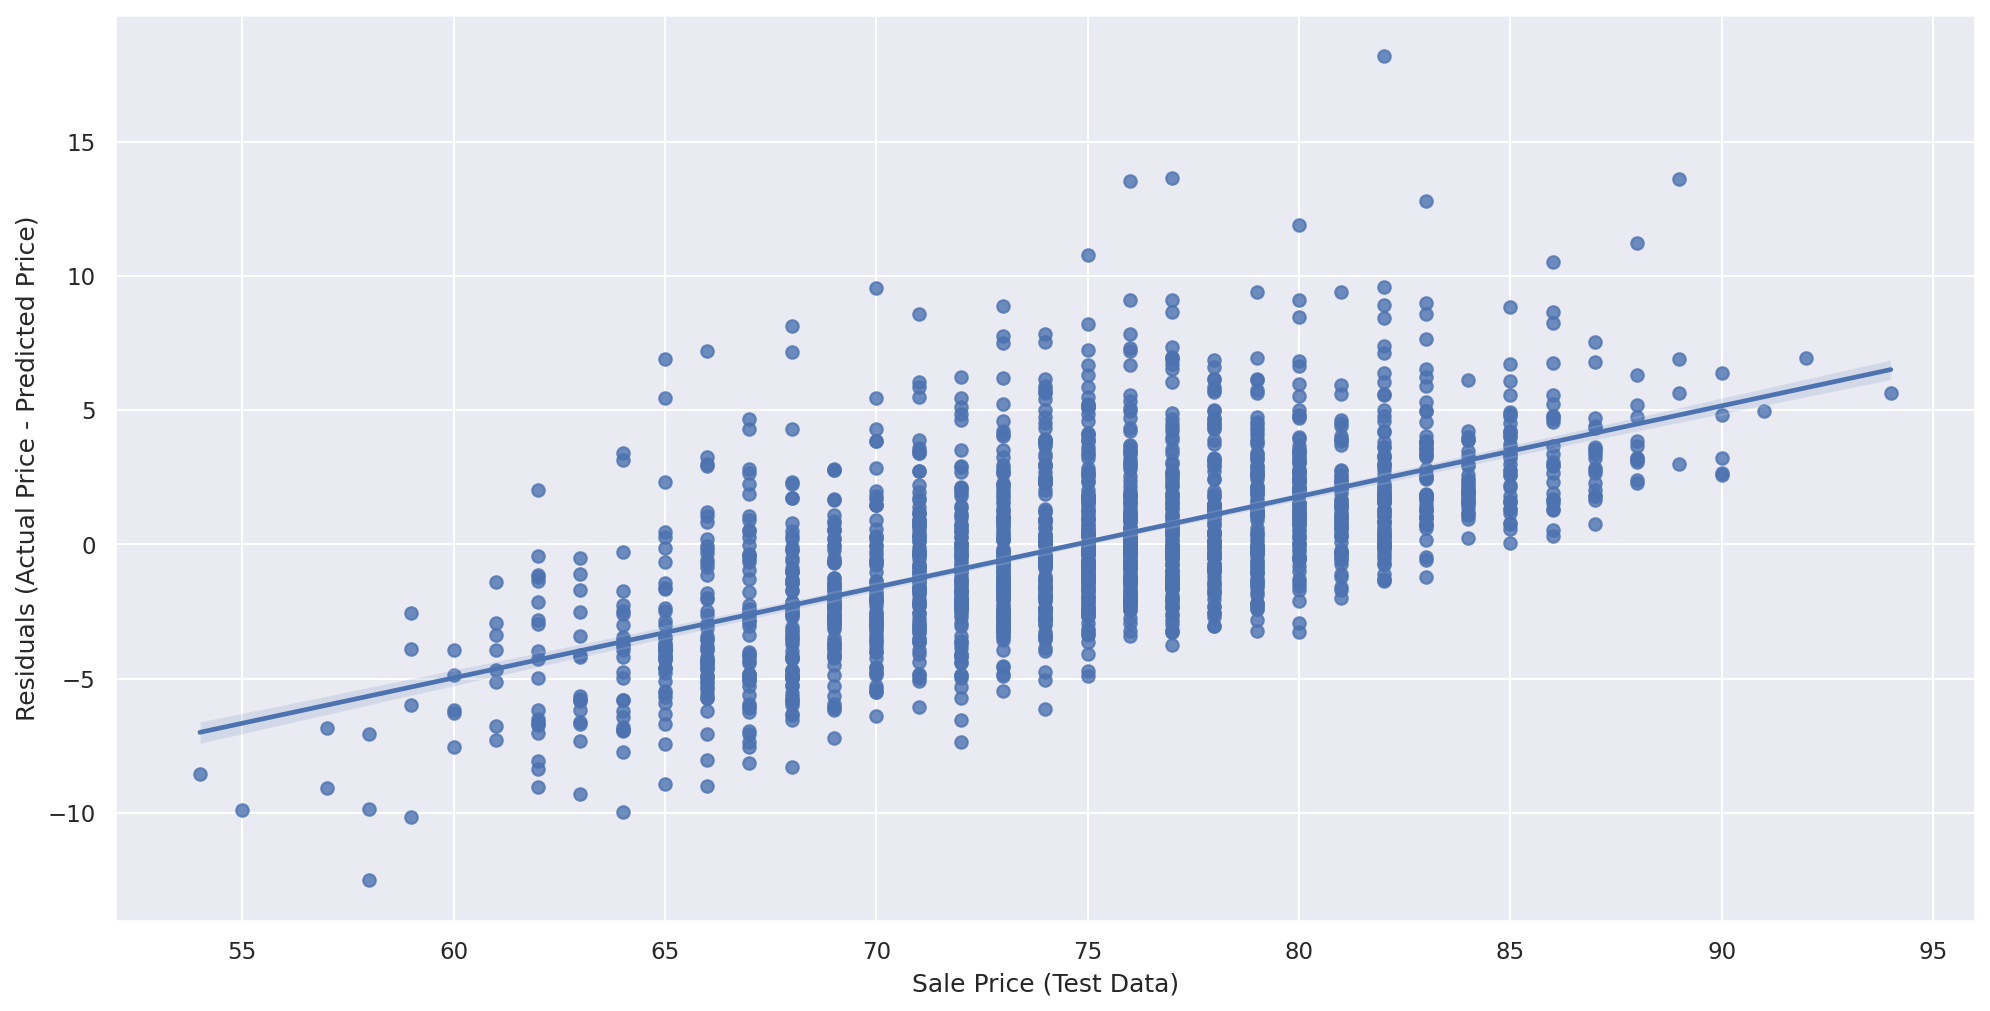

In [48]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

fm_residuals = y_train - y_predicted
ax = sns.regplot(y_train, fm_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')